In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
plt.style.use('seaborn')

In [2]:
city_day_df = pd.read_csv('../data/comparison_city_day.csv')

delhi_df = city_day_df.loc[city_day_df["City"] == "Delhi"]

In [3]:
delhi_df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [4]:
delhi_df = delhi_df.loc[:,["Date","AQI","PM2.5", "PM10", "SO2", "NOx", "NH3", "CO", "O3"]]

delhi_df.reset_index(inplace = True, drop = True)

In [5]:
delhi_df.head()

,Date,AQI,PM2.5,PM10,SO2,NOx,NH3,CO,O3
0,2015-01-01,472.0,313.22,607.98,9.25,110.59,33.85,15.20,41.68
1,2015-01-02,454.0,186.18,269.55,6.65,88.14,31.83,9.54,29.97
2,2015-01-03,143.0,87.18,131.90,2.65,47.95,69.55,10.61,19.71
3,2015-01-04,319.0,151.84,241.84,4.63,48.62,130.36,11.54,25.36
4,2015-01-05,325.0,146.60,219.13,3.33,38.25,122.88,9.20,23.20


## Replacing NAN with average of columns

In [6]:
delhi_df.fillna(delhi_df.mean(), inplace = True)

### Adding Features based on previous data

In [7]:
def average_of_N_previous_records(N, df, feature):
    df[f'{feature}_{N}'] = 0
    for i in range(N, len(df)):
        for n in range(1, N+1):
            df.loc[i, f'{feature}_{N}'] += df.loc[i-n, f'{feature}']
    df.loc[:,f'{feature}_{N}'] /= N
    df.loc[:N-1, f'{feature}_{N}'] = np.nan

In [8]:
cols = ["AQI"]

df_AQI = delhi_df.loc[:,["AQI"]]

for val in cols:
    for j in range(2,16):
        average_of_N_previous_records(j,df_AQI,val)

df_AQI = df_AQI.loc[15:].reset_index(drop = True)

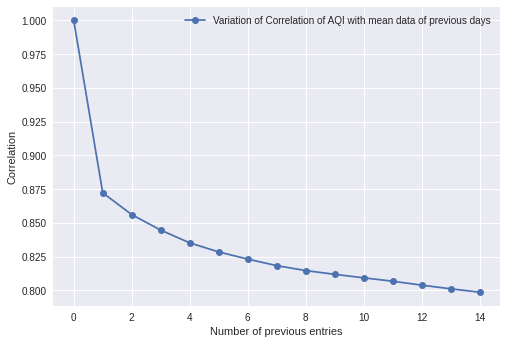

In [9]:
df_corr = df_AQI[df_AQI.columns].corr()['AQI']

plt.plot([i for i in range(15)],df_corr, marker = 'o', label = 'Variation of Correlation of AQI with mean data of previous days')
plt.xlabel('Number of previous entries')
plt.ylabel('Correlation')
plt.legend()

In [10]:
cols = list(delhi_df.columns)
cols.remove("Date")

for val in cols:
    average_of_N_previous_records(3,delhi_df,val)
    average_of_N_previous_records(5,delhi_df,val)
    average_of_N_previous_records(10,delhi_df,val)
#     average_of_N_previous_records(15,delhi_df,val)

delhi_df = delhi_df.loc[10:].reset_index(drop = True)

/home/chinmay/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



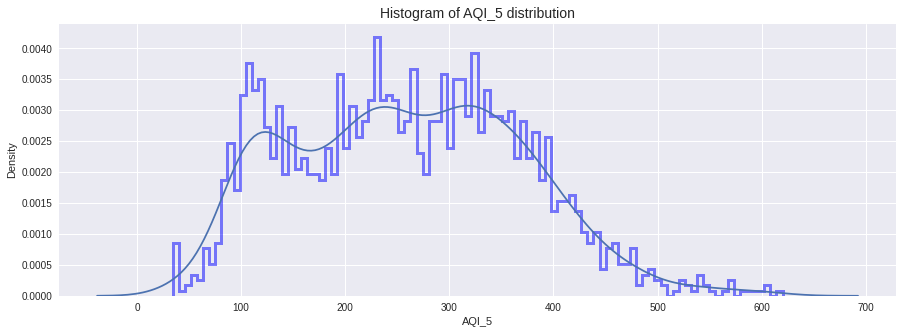

In [11]:
plt.figure(figsize = (15,5))
plot = sn.distplot(delhi_df.AQI_5,bins = 100, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.5, "color": "blue"});
plot.set_title('Histogram of AQI_5 distribution', fontsize = 14);

### Splitting the Data into Test and Validation set

In [12]:
y_cols = ['Date','AQI','PM2.5', 'PM10', 'SO2', 'NOx', 'NH3', 'CO', 'O3']
x_cols = list(set(delhi_df.columns) - set(y_cols))
x_cols.sort()

x = delhi_df.loc[:,x_cols]
y = delhi_df.loc[:,y_cols]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Normalization

In [13]:
from sklearn.preprocessing import PowerTransformer

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Applying Model

In [14]:
from sklearn.linear_model import Ridge

model = Ridge()

model.fit(x_train_scaled,y_train["AQI"])

y_pred = model.predict(x_test_scaled)


r2_score = model.score(x_test_scaled,y_test["AQI"])
print(r2_score)

0.7891622912657402


/home/chinmay/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



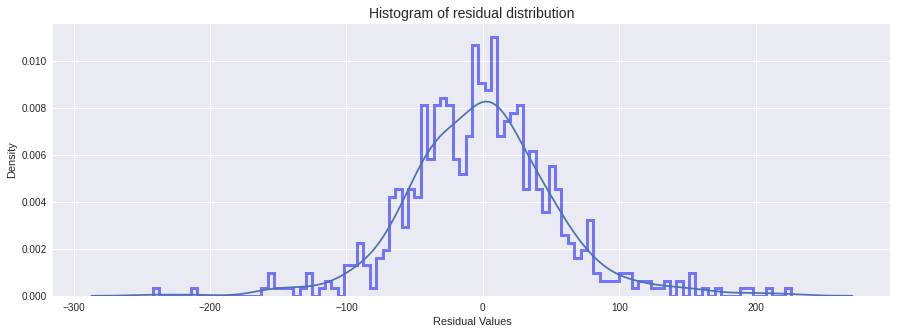

In [15]:
y_residual = y_test["AQI"] - y_pred

plt.figure(figsize = (15,5))
plot = sn.distplot(y_residual,bins = 100, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.5, "color": "blue"});
plt.xlabel("Residual Values")
plot.set_title('Histogram of residual distribution', fontsize = 14);

### PCA does not work

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [17]:
temp = pca.explained_variance_ratio_
print(temp)
sum(temp)

[0.62384536 0.18018649 0.06733744 0.04579468 0.0306395  0.01897691
 0.01090086 0.00527597]


0.9829572017796381

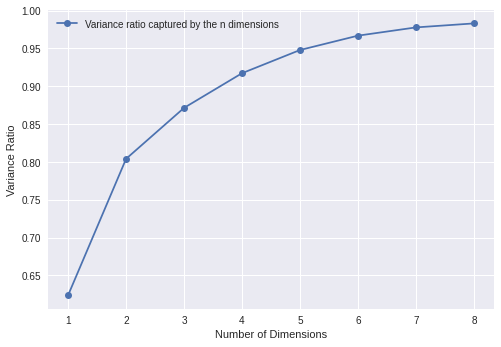

In [18]:
plt.plot([i for i in range(1,9)], np.cumsum(temp),marker = 'o', label = 'Variance ratio captured by the n dimensions')
plt.xlabel('Number of Dimensions')
plt.ylabel('Variance Ratio')
plt.legend()

In [19]:
from sklearn.linear_model import Ridge

model = Ridge()

model.fit(x_train_pca,y_train['AQI'])

r2_score = model.score(x_test_pca,y_test['AQI'])
print(r2_score)

0.7295863357688676


### RFE

In [20]:
r2scores_list = []
r2scores_train_list = []

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

for val in range(2,21):
    selector = RFE(Lasso(), n_features_to_select=val, step=1)

    x_train_rfe = selector.fit_transform(x_train_scaled,y_train["AQI"])
    x_test_rfe = selector.transform(x_test_scaled)
    
#     model = XGBRegressor(max_depth = 15,n_estimators = 10)
    model = Ridge()

    model.fit(x_train_rfe,y_train["AQI"])

    r2_score = model.score(x_test_rfe,y_test["AQI"])
    r2_score_train = model.score(x_train_rfe,y_train["AQI"])
    r2scores_list.append(r2_score)
    r2scores_train_list.append(r2_score_train)
    print(val,r2_score_train, r2_score)


2 0.7333414296413013 0.7465320634616617
3 0.7378739480340195 0.7485792042306033
4 0.7552072097543315 0.7675899486256662
5 0.7579898616037658 0.7737028037729686
6 0.7598309701577747 0.7738716945109259
7 0.7609779458358487 0.7754306313924849
8 0.7635343209098906 0.7784006625883333
9 0.7638187422016283 0.7796363926603879
10 0.763843821206944 0.7797794349330383
11 0.7651123215934772 0.7795776771362912
12 0.7651716806645934 0.7793817783507025
13 0.7667592080622253 0.7826354836058519
14 0.7668512894436573 0.7827321594661457
15 0.766871736335015 0.7827825818809044
16 0.767573106718489 0.78358418640187
17 0.7695810618174304 0.7831878350913799
18 0.769960721471663 0.7838419019586291
19 0.7735441734160445 0.7892266430196541
20 0.7736862457783774 0.7899687743512678


In [21]:
y_test['Date'] = pd.to_datetime(y_test['Date'])

y_test_reset = y_test.reset_index(drop = True)

y_test_reset['pred'] = y_pred
y_test_reset.sort_values(['Date'], inplace = True)

/home/chinmay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



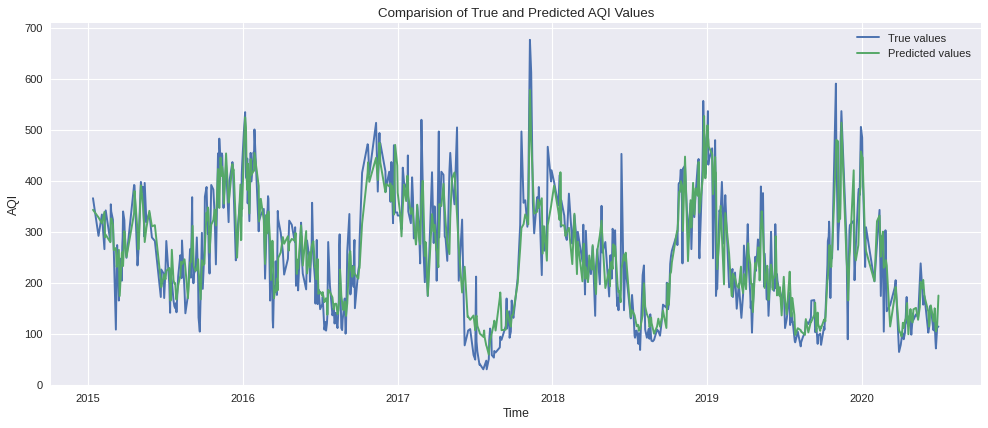

In [22]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)

plt.plot(y_test_reset['Date'],y_test_reset['AQI'], label = 'True values')
plt.plot(y_test_reset['Date'],y_test_reset['pred'], label = 'Predicted values')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Comparision of True and Predicted AQI Values')
plt.legend()

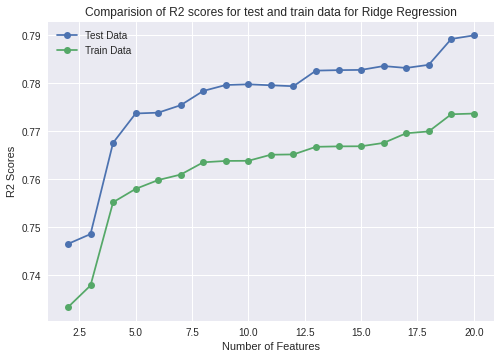

In [23]:
plt.plot([i for i in range(2,21)], r2scores_list,marker = 'o', label = "Test Data")
plt.plot([i for i in range(2,21)], r2scores_train_list,marker = 'o', label = "Train Data")
plt.xlabel('Number of Features')
plt.ylabel('R2 Scores')
plt.title("Comparision of R2 scores for test and train data for Ridge Regression")
plt.legend()

### Decision Tree

In [24]:
# from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=0, min_samples_leaf = 20)

model.fit(x_train_scaled,y_train["AQI"])

# y_pred = model.predict(x_test_scaled)

r2_score = model.score(x_test_scaled,y_test["AQI"])
print(r2_score)

0.742968799154364


In [25]:
model.get_depth()

9

In [26]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(x_train_scaled,y_train["AQI"])

# y_pred = model.predict(x_test_scaled_poly)

r2_score = model.score(x_test_scaled,y_test["AQI"])
print(r2_score)

0.7652929587372076


### Polynomial Features

In [27]:
poly = PolynomialFeatures(2, interaction_only = True)

x_train_scaled_poly = poly.fit_transform(x_train_scaled)

x_test_scaled_poly = poly.transform(x_test_scaled)

# delhi_df_poly = pd.DataFrame(new_data)

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

for val in range(30,310,10):
    selector = RFE(Ridge(), n_features_to_select=val, step=10)

    x_train_rfe = selector.fit_transform(x_train_scaled_poly,y_train["AQI"])
    x_test_rfe = selector.transform(x_test_scaled_poly)
    
#     x_train_rfe = selector.fit_transform(x_train,y_train)
#     x_test_rfe = selector.transform(x_test)
    
#     model = Ridge()
#     model = MultiOutputRegressor(XGBRegressor(max_depth = 15))
#     model = XGBRegressor(max_depth = 15,n_estimators = 10)

#     model = DecisionTreeRegressor(random_state=0, min_samples_leaf = 10)

    model.fit(x_train_rfe,y_train["AQI"])

    r2_score = model.score(x_test_rfe,y_test["AQI"])
    r2_score_train = model.score(x_train_rfe,y_train["AQI"])
    print(val,r2_score_train, r2_score)


30 0.9990527710226632 0.7635432791624566
40 0.9995651134105329 0.773335345450437
50 0.999608744844558 0.7719716757481027
60 0.9995727525424353 0.752658295726838
